---
title: Calculating 'Team-Attention' within Company using Viewer Statistics of Intranet Posts
description: 회사의 인트라넷에 공개된 게시글의 조회 통계를 통해 각 유닛(팀)의 '관심도'(또는, 업무 관련성)를 추정해보는 실험입니다.
author: johnjoon2004
date: 2025-06-08
categories: [EXPERIMENTAL, JUST-FOR-FUN]
image: ../images/post_250608_team_distance/heatmap.png
draft: false
---

:::{.callout-warning}
## THIS IS IMPORTANT
데이터 크롤링에 앞서, 어떠한 데이터를 수집하더라도 실행 전 <u>**반드시 해당 사이트 및 조직의 크롤링 정책을 확인**</u>하고, 수집 동작이 운영에 지장이 없도록 각별히 주의해야 합니다. 또한 수집 시 <u>**개인정보를 회피**</u>하여, 이것이 아예 크롤링 프로세스에 인입되지 않도록 구현하는 것이 좋습니다.

본 실험에 활용된 데이터는 수집 전 상급자 및 인프라 담당자의 동의를 거쳤으며, 수집된 데이터에는 민감 정보가 일체 포함되어 있지 않습니다. 해당 데이터는 회사의 정책에 따라 외부에 노출, 전송, 복사 등이 이뤄지지 않고 있으며, 실험 목적 외에는 사용되지 않습니다.

:::

## 1. 실험 설명

본 실험은 회사의 인트라넷에 공개된 게시글의 조회 통계를 통해 각 유닛(팀) 간의 '관심도'를 정량적으로 추정해보는 실험입니다. 여기서 **관심도**란, 서로 다른 유닛 사이의 **업무 관련도**, **협업의 강도**로 해석될 수 있습니다.

대부분의 회사에는 다양한 직군과 유닛들이 공존합니다. 만약 각 유닛 간의 업무 관련성, 또는 협업 강도를 정량적으로 분석할 수 있는 척도가 있다면, 이를 기반으로 <u>유닛 간 협업과 커뮤니케이션 상태를 점검 및 조율하고, 조직 구성을 최적화</u>하는 등, 기업 운영 시 매우 유용하게 활용될 여지가 있습니다.

- 예를 들어, 회사의 사무 공간이 부득이하게 분산되어 있다고 가정해봅시다. 회사의 사무실이 총 3개의 층으로 나뉘어 있는 상태이며, 건물의 2층, 3층, 그리고 19층에 각 유닛을 배치해야 하는 상황입니다. 이 때, 각 유닛 간의 협업/관련 정도을 정량적으로 측정할 수 있다면, <u>업무 관련성이 높은 유닛들을 가까운 공간에 배치</u>하고, 반대로 <u>업무 관련성이 낮은 유닛들은 서로 멀리 배치</u>하여도 무방하기에, 협업 효율을 최적화할 수 있는 공간 배치 전략을 수립할 수 있습니다.

## 2. 기본 접근법

회사의 인트라넷에 게재된 게시글 데이터를 수집하여 유닛간 거리 분석 실험 데이터셋으로 활용합니다.

- 저희 회사는 모든 구성원이 하나의 통일된 인트라넷 플랫폼에서 모든 문서 작업을 "Wiki-way"로 수행합니다. 

- 모든 게시글에 조회 기록이 자동으로 남겨지는 점을 활용합니다. 각 게시글은 **작성자**, **조회자** 및 조회자별 열람 횟수 등 정보를 포함하고 있습니다. 이를 통해 **작성자-조회수 맵핑**을 통해 유닛 간 상호작용을 모델링할 수 있습니다.

일반적인 IT 기업에는 기획, 연구 개발, 운영, 인사, 영업 등 직무가 존재하며, 저희 회사 또한 이와 유사한 조직 구조를 가지고 있습니다. 때문에 회사는 다양한 유형의 업무 수행을 지원하기 위해 꽤나 많은 게시판을 인트라넷에 구축해두었고, 각 유닛(팀)마다 주로 사용하는 게시판이 나뉘게 됩니다. 또한 각 게시글은 게시판 및 작성자가 속한 유닛과 따라 그 내용이 상당히 다른 특성을 지니게 됩니다. 

- 따라서 <u>각 게시판의 특성에 따라 메트릭 또는 가중치를 별도로 처리</u>하는 과정이 필요할 수 있습니다.

## 3. 실험 환경 세팅

실험에 사용될 라이브러리는 (일단은) 다음과 같습니다. 이들을 `import` 해줍니다.

In [1]:
import math
import re
from collections import defaultdict
from typing import Dict

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

데이터를 로드해줍니다. 본 실험에서는 `csv` 형식의 원본 데이터 파일이 이미 확보되어 있는 상태를 가정합니다.

In [2]:
data = pd.read_csv("../private/post_250608_team_distance/company_posts.csv")

## 4. 데이터 분석(EDA) 및 전처리

먼저 데이터에 포함된 칼럼들을 확인해봅니다.

In [3]:
data.columns

Index(['Unnamed: 0', 'link', 'title', 'creator', 'board', 'text', 'readers'], dtype='object')

각 칼럼의 의미는 다음과 같습니다:

| 칼럼     | 설명                        | 필요 여부 |
|----------|-----------------------------|:---------:|
| Unnamed: 0     | 게시글의 인덱스                |    X     |
| link     | 게시글의 URL                |    X     |
| title    | 게시글 제목                 |    X     |
| creator  | 게시글 작성자               |    O     |
| board    | 게시글이 속한 게시판         |    O     |
| text     | 게시글 본문                 |    X     |
| readers  | 게시글 조회자 및 조회수 목록 |    O     |


불필요한 칼럼을 제거합니다.

In [4]:
cols_to_remove = ["Unnamed: 0", "link", "title", "text"]
data.drop(columns=cols_to_remove, inplace=True)

게시판(`board`) 칼럼의 경우, 조금 더 세부적으로 분류할 필요가 있습니다. 

대부분의 게시판의 경우, 게시글들이 개인 또는 특정 유닛이 대부분을 기여하지만, 특정 게시판의 경우 범-유닛 단위로, 또는 전사적으로 공통 작성/유지보수되는 경우가 있기 때문입니다. 후자에 해당하는 게시글의 경우, 여러 유닛이 작성에 기여했으나, <u>조회수의 모든 기여분이 최초 작성자에 편중되는 문제</u>가 발생할 수 있습니다. 따라서 본 실험에서는 저의 주관에 따라 모든 게시판을 전자에 해당한다고 판단될 경우 `isolation` 그룹으로, 후자에 해당한다고 판단될 경우 `association` 그룹으로 분류하고, 다음과 같은 naive한 방식으로 구분지어 처리합니다. (본 실험에서는 이 부분에서 deep dive하지 않습니다😿)

-  `isolation` 그룹에 속하는 모든 게시글의 조회수에 `1.0` 만큼의 가중치를 적용시킵니다.
- `association` 그룹에 속하는 모든 게시글의 조회수에 `0.5` 만큼의 가중치를 적용시킵니다.

위와 같은 기준에 따라 게시판 유형(`board_type`) 태그를 데이터셋에 새로운 칼럼으로 추가하고, 불필요한 게시판 항목은 제거합니다. (전체 게시판 정보를 출력할 수 없는 점 양해 바랍니다)

In [5]:
import sys
if ".." not in sys.path:
    sys.path.append("..")
from private.post_250608_team_distance.board_categories import boards_isolation, boards_association

In [6]:
sample_isolation_boards = (
    "연구노트",
    "개발노트",
    "개인게시판",
    ...
)

sample_association_boards = (
    "회의록",
    "교육자료",
    "제품매뉴얼",
    ...
)

In [7]:
data = data[data["board"].isin(boards_isolation + boards_association)].reset_index(drop=True)

In [8]:
def calculate_weight_by_board(board):
    if board in boards_isolation:
        return 1
    elif board in boards_association:
        return 0.5
    else:
        raise

data["board_weight"] = data["board"].apply(calculate_weight_by_board)

각 유닛 구성원(재직자) 목록을 로드합니다. 다음과 같은 형식의 직원 목록 `json` 파일을 확보한 상태로 가정합니다.

In [9]:
_employees = pd.read_json("../private/post_250608_team_distance/employees.json")

In [10]:
sample_employees = [
    {
        "name": "홍길동",
        "unit": "개발1유닛"
    },
    {
        "name": "김철수",
        "unit": "개발2유닛"
    },
    ...
]

퇴사자가 작성한 게시글의 경우 현재의 unit 정보를 불러올 수 없으므로 제거합니다.

In [11]:
data = data[data["creator"].isin(_employees["name"].tolist())].reset_index(drop=True)

작성자의 유닛을 식별 불가한 게시글을 제거합니다. ('토마스'는 사내 시스템에서 익명화 시 사용되는 가상 인물입니다)

In [12]:
data = data[data["creator"] != "토마스"].reset_index(drop=True)

구성원-유닛 정보를 매핑하고, 게시글 데이터셋에 작성자의 유닛 정보를 추가합니다.

In [13]:
_unit_map = {}

def get_unit(name: str) -> str:
    if name not in _unit_map:
        _unit_map[name] = _employees[_employees["name"] == name]["unit"].values[0]
    return _unit_map[name]

data["unit"] = data["creator"].apply(get_unit)

In [14]:
data = data[data["unit"] != "무하유"].reset_index(drop=True)

데이터셋에 포함된 모든 실명을 `Faker` 라이브러리를 사용해 익명화 처리합니다.

In [15]:
from faker import Faker

faker = Faker("ko_KR")

![Faker](../images/post_250608_team_distance/faker.jpg)

In [16]:
_name_map = {}

def get_fake_name(real_name: str) -> str:
    if real_name not in _name_map:
        _name_map[real_name] = faker.name()
    return _name_map[real_name]

data["creator"] = data["creator"].apply(get_fake_name)

In [17]:
fake_unit_map = {}
for name, unit in _unit_map.items():
    fake_unit_map[get_fake_name(name)] = unit

마지막으로 조회자 목록(`readers`)에 대한 전처리를 진행합니다. 

기존 `readers` 칼럼에는 '*...홍길동(5) 김꺽정(1) ...*'과 같은 형식으로 작성자와 조회수가 포함되어 있습니다. 이를 파싱 및 조회자의 유닛 정보를 매핑하여 조회자-유닛-조회수 필드를 포함한 `dict` 형식의 `readers` 칼럼으로 재구성합니다.

In [18]:
def parse_readers(readers_text: str) -> list[Dict[str, int]]:
    pttn = re.compile(r"([가-힣A-Za-z]+)\((\d+)\)")
    readers = pttn.findall(readers_text)
    readers_parsed = []
    for name, count in readers:
        if name not in _unit_map:
            continue
        fake_name = get_fake_name(name)
        unit = _unit_map[name]
        readers_parsed.append({
            "name": fake_name,
            "unit": unit,
            "count": int(count),
        })
    return readers_parsed

data["readers"] = data["readers"].apply(parse_readers)

실명이 포함된 데이터는 삭제합니다. (앞으로 표시되는 이름은 모두 익명화 처리된 이름입니다)

In [19]:
del _employees, _unit_map, _name_map

전처리 완료된 데이터셋의 예시는 다음과 같습니다:

In [20]:
data.head()

,creator,board,readers,board_weight,unit
0,김종수,개인업무계획,"[{'name': '김종수', 'unit': '개발10유닛', 'count': 23...",1.0,개발10유닛
1,이영진,회의록,"[{'name': '노아름', 'unit': '개발6유닛', 'count': 9},...",0.5,비즈니스유닛
2,이영진,영업,"[{'name': '노아름', 'unit': '개발6유닛', 'count': 11}...",1.0,비즈니스유닛
3,김민석,개발노트,"[{'name': '노아름', 'unit': '개발6유닛', 'count': 9},...",1.0,개발6유닛
4,김민석,제품매뉴얼,"[{'name': '노아름', 'unit': '개발6유닛', 'count': 9},...",0.5,개발6유닛


In [21]:
data.iloc[0]["readers"]

[{'name': '김종수', 'unit': '개발10유닛', 'count': 233},
 {'name': '손종수', 'unit': '비즈니스유닛', 'count': 19},
 {'name': '이민재', 'unit': '개발10유닛', 'count': 18},
 {'name': '장옥자', 'unit': 'CEM유닛', 'count': 15},
 {'name': '노아름', 'unit': '개발6유닛', 'count': 11},
 {'name': '한은서', 'unit': '무하유', 'count': 6},
 {'name': '이재현', 'unit': '개발10유닛', 'count': 5},
 {'name': '안영미', 'unit': '비즈니스유닛', 'count': 5},
 {'name': '임영희', 'unit': '개발5유닛', 'count': 3},
 {'name': '김상호', 'unit': '개발10유닛', 'count': 2},
 {'name': '고준서', 'unit': '개발6유닛', 'count': 2},
 {'name': '우시우', 'unit': '개발10유닛', 'count': 2},
 {'name': '강민수', 'unit': '개발10유닛', 'count': 2},
 {'name': '박경숙', 'unit': '개발15유닛', 'count': 1},
 {'name': '최혜진', 'unit': '개발5유닛', 'count': 1},
 {'name': '이예진', 'unit': '개발10유닛', 'count': 1},
 {'name': '안주원', 'unit': '개발5유닛', 'count': 1},
 {'name': '정정식', 'unit': 'CEM유닛', 'count': 1},
 {'name': '김영희', 'unit': '데이터팩토리1유닛', 'count': 1},
 {'name': '진서준', 'unit': '기획3유닛', 'count': 1},
 {'name': '박정순', 'unit': '경영지원유닛', 'count'

In [22]:
print("데이터셋 크기: ", len(data))

데이터셋 크기:  5138


## 5. Team-Attention 계산 알고리즘

이제 본격적으로 게시글별 조회 통계를 기반으로 유닛 간의 '관심도'를 계산하는 알고리즘을 구현합니다.

각 게시글의 조회자 목록(`readers`)을 순회하며, 각 조회자의 유닛과 조회수를 합산하는 방식입니다. 이 때, 다음 사항을 유의해야 합니다:
- 조회 통계에는 본인의 열람 기록 또한 포함되어 있기 때문에, 이를 제외하고 계산해야 합니다.
- 특정 게시글에 특정 인원의 조회수가 과도하게 높은 경우가 있습니다. 이는 해당 인원이 해당 게시글을 주로 유지보수하는 역할이거나, 반복적으로 팔로우업 했던것이 원인일 가능성이 높습니다. 이는 해당 유닛과 게시글 간의 실제 관련성을 왜곡할 수 있으므로, **Sigmoid 함수를 적용**하여 과도하게 높은 조회수를 조정할 필요가 있습니다. (본 실험에서는 1~10 범위로 정규화합니다)
- 이러한 정규화가 반영하는 중요한 관점은, 조회수가 없는 것과, 1회 또는 2회 정도의 조회수를 보인 것은 매우 유의미한 차이라고 볼 수 있으나, 무작정 높은 조회수를 보였다고 해서 그만큼 업무 관련성/관심도가 높다고 볼 수는 없다는 것입니다. 가령, 100회 또는 그 이상의 조회수는 사실상 10회 이상의 조회수와 구분되는 만큼의 의미를 가지지 않는다고 판단합니다. 아래의 수식은 이러한 관점을 반영합니다.

$$
\text{sigmoid-scaled}(x) = 1 + 9 \times \frac{\sigma(\alpha(x - 1)) - \sigma(0)}{1 - \sigma(0)}
$$

$$
\text{where} \quad \sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [23]:
def sigmoid(x, alpha=0.5):
    s0 = 1 / (1 + np.exp(-alpha * (1 - 1)))
    sX = 1 / (1 + np.exp(-alpha * (x - 1)))
    y = 1 + 9 * (sX - s0) / (1 - s0)
    return y

def sigmoid_count(readers: list[dict]):
    return [{**reader, "count": sigmoid(reader["count"])} for reader in readers]

data["readers"] = data["readers"].apply(sigmoid_count)

위를 실행하면 조회수가 다음과 같이 0 ~ 10 범위로 정규화됩니다:

In [24]:
data.iloc[0]["readers"]

[{'name': '김종수', 'unit': '개발10유닛', 'count': np.float64(10.0)},
 {'name': '손종수', 'unit': '비즈니스유닛', 'count': np.float64(9.997778897632246)},
 {'name': '이민재', 'unit': '개발10유닛', 'count': np.float64(9.996338314395006)},
 {'name': '장옥자', 'unit': 'CEM유닛', 'count': np.float64(9.98360107850079)},
 {'name': '노아름', 'unit': '개발6유닛', 'count': np.float64(9.879528683362874)},
 {'name': '한은서', 'unit': '무하유', 'count': np.float64(8.634552759617618)},
 {'name': '이재현', 'unit': '개발10유닛', 'count': np.float64(7.854347403601881)},
 {'name': '안영미', 'unit': '비즈니스유닛', 'count': np.float64(7.854347403601881)},
 {'name': '임영희', 'unit': '개발5유닛', 'count': np.float64(5.159054415340088)},
 {'name': '김상호', 'unit': '개발10유닛', 'count': np.float64(3.2042679616333825)},
 {'name': '고준서', 'unit': '개발6유닛', 'count': np.float64(3.2042679616333825)},
 {'name': '우시우', 'unit': '개발10유닛', 'count': np.float64(3.2042679616333825)},
 {'name': '강민수', 'unit': '개발10유닛', 'count': np.float64(3.2042679616333825)},
 {'name': '박경숙', 'unit': '개발1

이제 유닛 간 전체 '관심도'(`unit_total_attention`)를 계산합니다.

먼저 각 게시글의 작성자(`creator`)와 조회자(`reader`)의 소속 유닛을 쌍(tuple)로 묶어 '관심 방향'을 표현하고, 이러한 관심의 '강도'를 기존에 계산해둔 정규화된 조회수 및 가중치를 통해 계산합니다.

In [25]:
unit_total_attentions = defaultdict(float)
for _, post in data.iterrows():
    unit1 = post["unit"]
    board_weight = post["board_weight"]
    for reader in post["readers"]:
        unit2 = reader["unit"]
        unit_total_attentions[(unit1, unit2)] += reader["count"] * board_weight

그런 다음, 유닛별 구성원의 수를 전체 관심도(`unit_total_attention`)에 나누어 평균 관심도(`unit_avg_attention`)를 계산합니다.

In [26]:
unit_set = data["unit"].unique().tolist()

unit_avg_attentions = defaultdict(float)
for unit1 in unit_set:
    unit_members = data[data["unit"] == unit1]["creator"].unique().tolist()
    term = len(unit_members)
    for unit2 in unit_set:
        vec = (unit1, unit2)
        unit_avg_attentions[vec] = unit_total_attentions[vec] / term

드물긴 하지만, 어떤 유닛에서 특정 유닛에 대한 관심도가 0일 경우(즉, 조회수가 0), 이를 명시해줍니다.

In [27]:
for unit1 in unit_set:
    for unit2 in unit_set:
        if (unit1, unit2) not in unit_avg_attentions:
            unit_avg_attentions[(unit1, unit2)] = 0.0

앞서 계산한 '관심도'는 방향성이 있습니다. 두 유닛 간의 관심도를 합산하는 방식으로 '상호 관심도'를 계산해봅니다. 이 때 계산된 값은 대칭성을 가지며 방향성이 없습니다.

In [28]:
unit_avg_attentions_bi = defaultdict(float)
for unit1 in unit_set:
    for unit2 in unit_set:
        vec = tuple(sorted([unit1, unit2]))
        avg_attn_score = unit_avg_attentions[vec]
        unit_avg_attentions_bi[vec] += avg_attn_score

계산된 조합이 맞는지 확인해봅니다.

In [29]:
assert len(unit_avg_attentions_bi.keys()) == math.comb(len(unit_set) + 1, 2)

모든 유닛 간 거리 값이 `unit_distances`에 올바르게 매핑된 것 같습니다.

# 6. 결과 시각화

이제 계산은 완료되었습니다! 이어서 결과를 시각화해봅니다.

In [30]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "C:/Windows/Fonts/malgun.ttf"
fontprop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

먼저 각 유닛 간의 관심도를 히트맵으로 시각화합니다. (시각화 효과를 위해서 특정한 범위의 스케일링을 적용하였습니다)

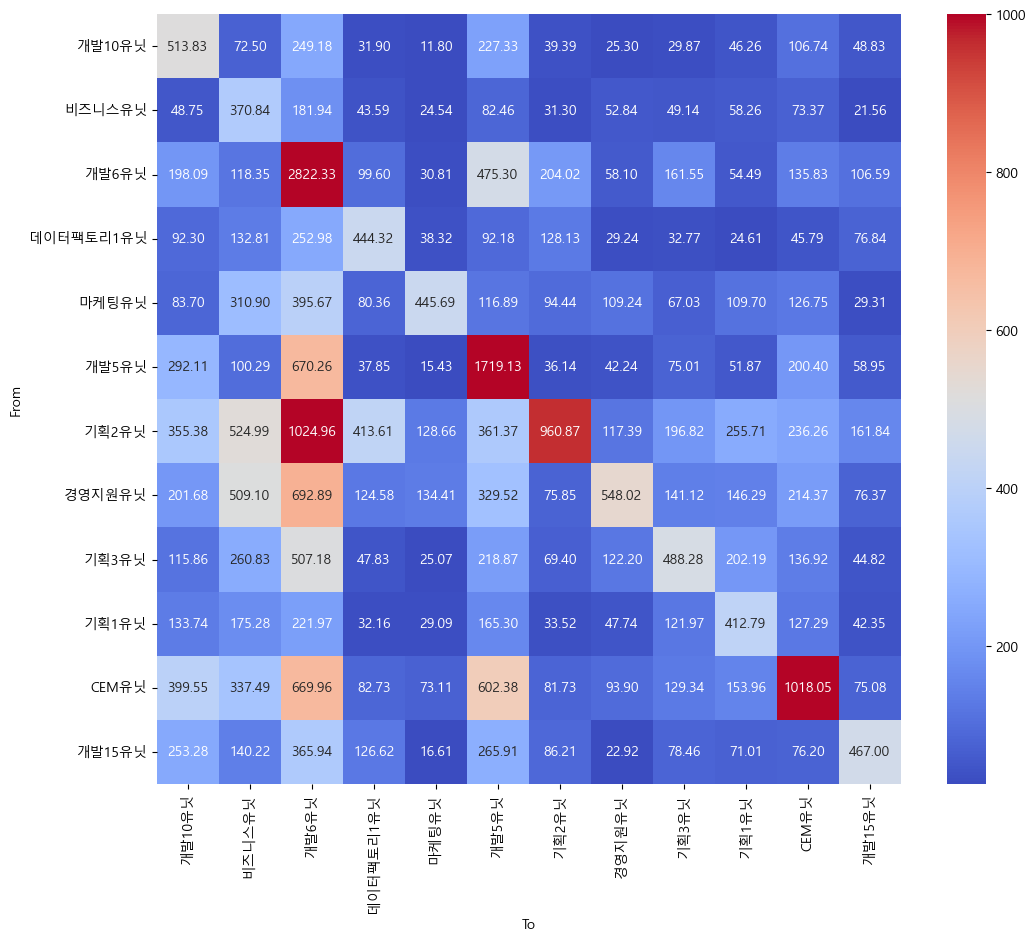

In [31]:
attn_matrix = pd.DataFrame(np.inf, index=unit_set, columns=unit_set)
for (unit1, unit2), distance in unit_avg_attentions.items():
    attn_matrix.loc[unit1, unit2] = distance

plt.figure(figsize=(12, 10))
sns.heatmap(
    attn_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    vmin=25, vmax=1000
)
plt.xlabel("To")
plt.ylabel("From")
plt.show()

:::{.callout-tip}
## Insight
- 유닛 간 관심도가 명확히 관찰되는 것 같습니다. 예를 들어, "기획2유닛"은 "개발6유닛"에 높은 관심도를 보이고 있었네요!
- 실제로도, "기획2유닛"은 사내 AI 제품군의 기획과 프로젝트 관리를 담당하는 조직으로, AI 모델/서비스 개발 및 서빙을 담당하는 "개발6유닛"과 매우 긴밀한 협업이 지속되어 왔습니다.
- 또한, "기획2유닛", "경영지원유닛"과 "CEM유닛"의 타 유닛들에 두루두루 관심을 보이는 경향 또한 흥미롭습니다. 😂
- 이에 비해 상대적으로 "시크한" 스타일의 유닛도 있는 것 같습니다...
- 그 중, "개발6유닛"은 자체 유닛원 간의 관심도가 외부 유닛에 비해 매우 높은 경향이 관찰됩니다. 구성원 중 누군가 게시글을 올리면 "개발6유닛"은 결코 법이 없습니다. 😅

:::

그래프 형태로도 관심도를 시각화해볼 수 있습니다.

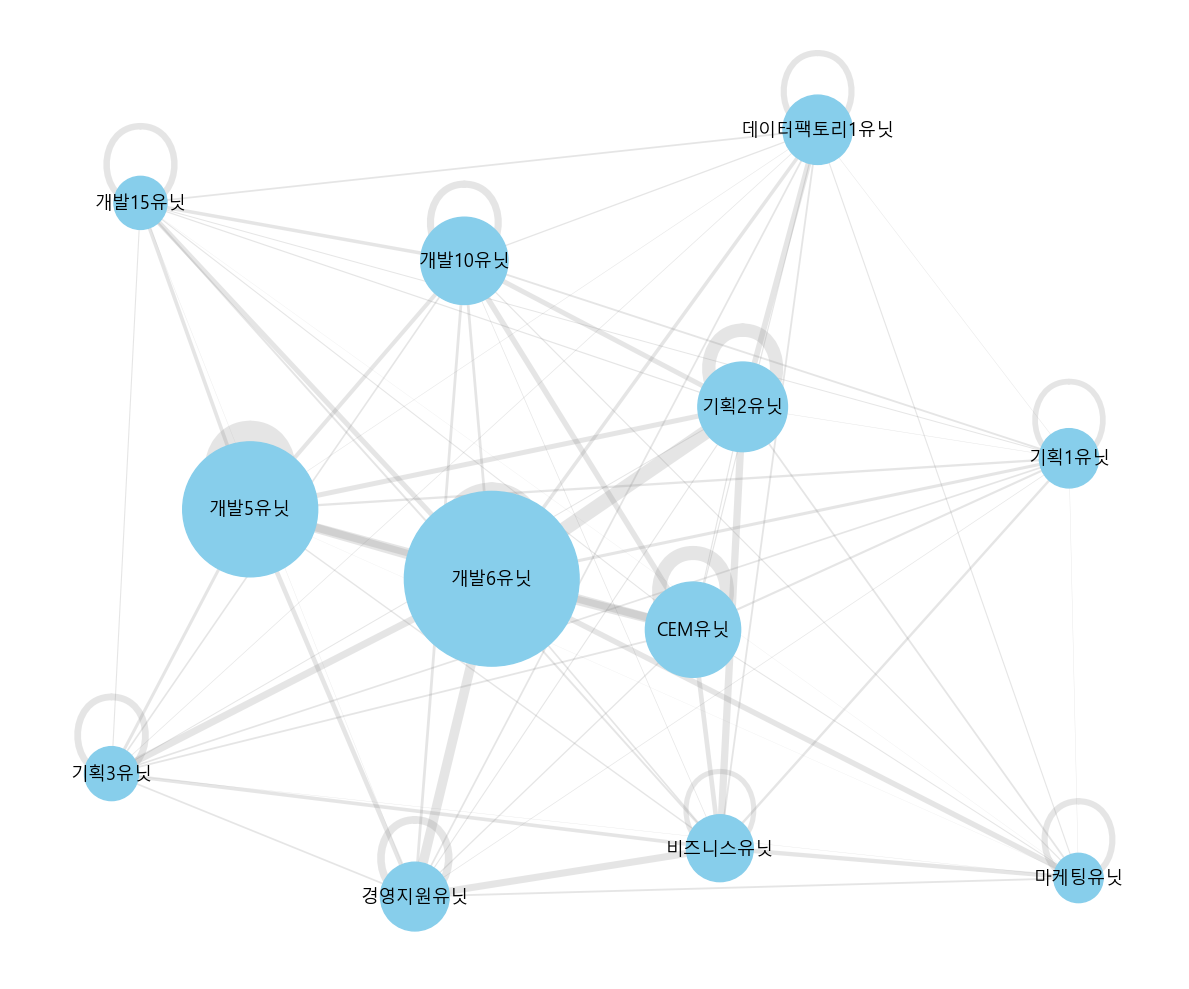

In [32]:
G = nx.Graph()
G.add_nodes_from(unit_set)
for (unit1, unit2), distance in unit_avg_attentions.items():
    G.add_edge(unit1, unit2, weight=distance)

unit_counts = data["unit"].value_counts().to_dict()
node_sizes = [10 * unit_counts.get(node, 1) for node in G.nodes]

pos = nx.spring_layout(G, seed=42, k=1.2, scale=3.0)
edges = G.edges(data=True)
edge_widths = [data['weight']/100 for _, _, data in edges]

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color="gray", alpha=0.2)

for node, (x, y) in pos.items():
    plt.text(
        x, y, s=node,
        fontproperties=fontprop,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=13,
        color="black"
    )

plt.axis("off")
plt.tight_layout()
plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
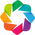

:Chord   [start,end]

In [33]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

chord_data = [
    (unit1, unit2, 1 / distance)
    for (unit1, unit2), distance in unit_avg_attentions_bi.items()
    if distance != float('inf')
]

chord = hv.Chord(chord_data)
chord.opts(
    opts.Chord(
        labels='index',
        cmap='Category20',
        edge_cmap='viridis',
        edge_color='weight',
        node_color='index',
        title="Unit Relationships (Chord Diagram)",
        width=1000,
        height=1000,
    )
)

chord

# 7. 결론

사내 인프라넷 상의 게시글의 조회수 통계를 기반으로 유닛 간 관심도를 계산하는 실험을 진행해보았습니다. 실험 결과, 실제로 협업이 긴밀하게 이뤄지는 부서 간 높은 관심도, 즉 게시글의 높은 조회 빈도가 입증되었습니다.

이를 통해 얻을 수 있는 인사이트는, 일종의 유닛 간 협업 상태를 평가하는 간접적인 척도가 도출되었다는 점입니다.